<a href="https://colab.research.google.com/github/chcorophyll/my_deeplearning_cookbook/blob/master/my_Song_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/chcorophyll/deep_learning_cookbook.git

Cloning into 'deep_learning_cookbook'...
remote: Enumerating objects: 427, done.
remote: Total 427 (delta 0), reused 0 (delta 0), pack-reused 427
Receiving objects: 100% (427/427), 160.26 MiB | 36.46 MiB/s, done.
Resolving deltas: 100% (207/207), done.
Checking out files: 100% (86/86), done.


In [2]:
!ls

deep_learning_cookbook	sample_data


In [0]:
import os 

path_org = os.getcwd()
path_data = os.path.join(path_org, "deep_learning_cookbook")

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)

import gc
import os
import ast
import sys
import configparser
import glob
import librosa
import librosa.display
from scipy.stats import mode

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import keras
from keras import backend as K

In [0]:
!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz
!tar xzf genres.tar.gz

--2019-07-14 01:36:27--  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Resolving opihi.cs.uvic.ca (opihi.cs.uvic.ca)... 142.104.68.135
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225573614 (1.1G) [application/x-gzip]
Saving to: ‘genres.tar.gz’

genres.tar.gz       100%[===================>]   1.14G  1.27MB/s    in 16m 50s 

2019-07-14 01:53:18 (1.16 MB/s) - ‘genres.tar.gz’ saved [1225573614/1225573614]



In [4]:
!ls

deep_learning_cookbook	sample_data


In [0]:
os.chdir(path_data)

In [0]:

def load_songs(song_folder):
    song_specs = []
    idx_to_genre = []
    genre_to_idx = {}
    genres = []
    for genre in os.listdir(song_folder):
        genre_to_idx[genre] = len(genre_to_idx)
        idx_to_genre.append(genre)
        genre_folder = os.path.join(song_folder, genre)
        for song in os.listdir(genre_folder):
            if song.endswith('.au'):
                signal, sr = librosa.load(os.path.join(genre_folder, song))
                melspec = librosa.feature.melspectrogram(signal, sr=sr).T[:1280,]
                song_specs.append(melspec)
                genres.append(genre_to_idx[genre])
    return song_specs, genres, genre_to_idx, idx_to_genre


In [0]:
path = os.path.join(path_org, "genres")
song_specs, genres, genre_to_idx, idx_to_genre = load_songs(path)
song_specs[0].shape

(1280, 128)

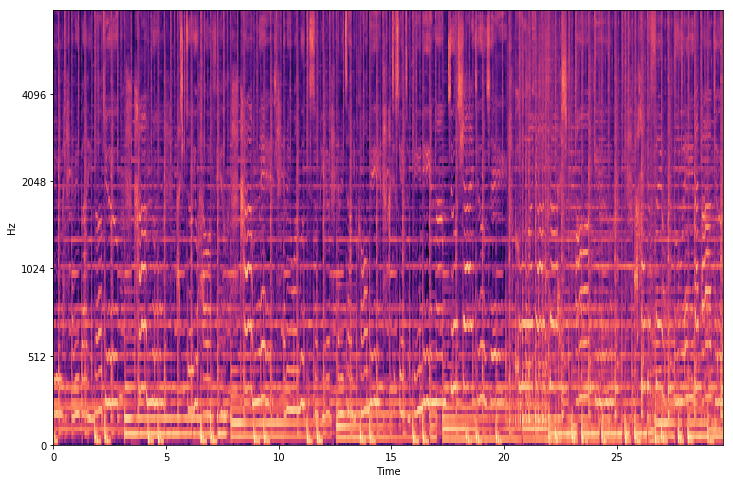

In [0]:
librosa.display.specshow(librosa.power_to_db(song_specs[101].T, ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')


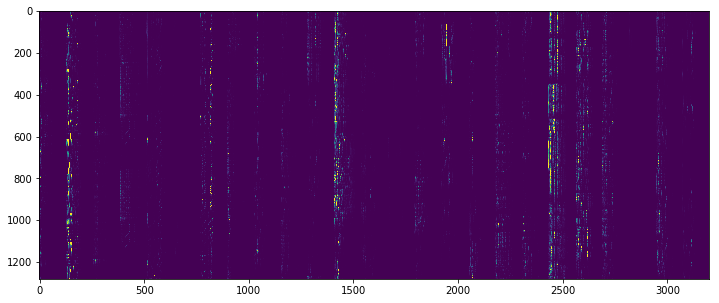

In [0]:
def show_spectogram(show_genre):
    show_genre = genre_to_idx[show_genre]
    specs = []
    for spec, genre in zip(song_specs, genres):
        if show_genre == genre:
            specs.append(spec)
            if len(specs) == 25:
                break
    if not specs:
        return 'not found!'
    x = np.concatenate(specs, axis=1)
    x = (x - x.min()) / (x.max() - x.min())
    plt.imshow((x *20).clip(0, 1.0))

show_spectogram('classical')
    

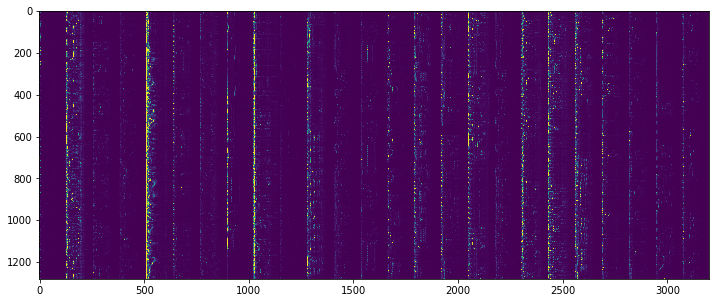

In [0]:
show_spectogram('metal')

In [0]:
def lstm_model(input_shape):
    inputs = Input(shape=input_shape, name='input')
    lstm_1 = LSTM(units=128, return_sequences=False)(inputs)
    
    dense2 = Dense(10, activation='softmax')(lstm_1)

    model = Model(inputs=[inputs], outputs=[dense2])
    sgd = keras.optimizers.SGD(lr=0.0003, momentum=0.9, decay=1e-5, nesterov=True)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

def cnn_model(input_shape):
    inputs = Input(input_shape)
    x = inputs
    levels = 64
    
    for level in range(3):
        x = Conv1D(levels, 3, activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        levels *= 2
    
    # Global Layers
    x = GlobalMaxPooling1D()(x)

    for fc in range(2):
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)

    labels = Dense(10, activation='softmax')(x)

    model = Model(inputs=[inputs], outputs=[labels])
    sgd = keras.optimizers.SGD(lr=0.0003, momentum=0.9, decay=1e-5, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

model = cnn_model((128, 128))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 126, 64)           24640     
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 64)           256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 63, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 61, 128)           24704     
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 128)           512       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 30, 128)           0         
__________

In [0]:
def split_10(x, y):
    s = x.shape
    s = (s[0] * 10, s[1] // 10, s[2])
    return x.reshape(s), np.repeat(y, 10, axis=0)


genres_one_hot = keras.utils.to_categorical(genres, num_classes=len(genre_to_idx))

x_train, x_test, y_train, y_test = train_test_split(
    np.array(song_specs), np.array(genres_one_hot), 
    test_size=0.1, stratify=genres)

x_test, y_test = split_10(x_test, y_test)
x_train, y_train = split_10(x_train, y_train)

x_train.shape, y_train.shape

((9000, 128, 128), (9000, 10))

In [0]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
      min_delta=0,
      patience=3,
      verbose=0,
      mode='auto')

    # Fit the model
history = model.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=1,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 3s 292us/step - loss: 3.4648 - acc: 0.1358 - val_loss: 2.0781 - val_acc: 0.2470
Epoch 2/100
9000/9000 [==============================] - 2s 182us/step - loss: 2.3938 - acc: 0.2040 - val_loss: 1.9551 - val_acc: 0.2660
Epoch 3/100
9000/9000 [==============================] - 2s 184us/step - loss: 2.1717 - acc: 0.2359 - val_loss: 1.9217 - val_acc: 0.2900
Epoch 4/100
9000/9000 [==============================] - 2s 180us/step - loss: 2.0710 - acc: 0.2529 - val_loss: 1.9002 - val_acc: 0.3080
Epoch 5/100
9000/9000 [==============================] - 2s 179us/step - loss: 2.0044 - acc: 0.2844 - val_loss: 1.8656 - val_acc: 0.3270
Epoch 6/100
9000/9000 [==============================] - 2s 181us/step - loss: 1.9579 - acc: 0.2973 - val_loss: 1.8394 - val_acc: 0.3520
Epoch 7/100
9000/9000 [==============================] - 2s 179us/step - loss: 1.9214 - acc: 0.3026 - val_loss: 1.8114 - val_acc: 

In [0]:
model.save('zoo/15/song_classify.h5')

In [0]:
def unsplit(values):
    chunks = np.split(values, 100)
    return np.array([np.argmax(chunk)%10 for chunk in chunks])

pred_values = model.predict(x_test)
predictions = unsplit(pred_values)
truth = unsplit(y_test)
accuracy_score(predictions, truth)

0.54

In [0]:
y_test.shape

(1000, 10)

In [0]:
pred_values.shape

(1000, 10)

In [0]:
chunks = np.split(pred_values, 100)
len(chunks)

100

In [0]:
chunks[0]

array([[0.01679951, 0.06745821, 0.05645249, 0.33255637, 0.01817837,
        0.04020517, 0.02109633, 0.03369313, 0.37305316, 0.04050726],
       [0.01229311, 0.09247205, 0.06844365, 0.28292152, 0.02045896,
        0.05200781, 0.0250242 , 0.04204212, 0.35903373, 0.0453028 ],
       [0.00715527, 0.03795531, 0.02083599, 0.37069908, 0.00677311,
        0.03600421, 0.01073209, 0.0310924 , 0.4610327 , 0.01771987],
       [0.01042611, 0.05544483, 0.02754136, 0.32771236, 0.02096439,
        0.11978234, 0.01898521, 0.03619772, 0.34469974, 0.03824592],
       [0.00885249, 0.07208227, 0.03587157, 0.41066915, 0.01116781,
        0.03565451, 0.01093984, 0.02073118, 0.37134752, 0.02268367],
       [0.01460686, 0.07044353, 0.03607186, 0.39809453, 0.02060231,
        0.03696763, 0.02204675, 0.04808261, 0.3170177 , 0.03606618],
       [0.00940016, 0.07427247, 0.07633706, 0.29186088, 0.04052236,
        0.09030931, 0.02792874, 0.04588123, 0.2984741 , 0.04501374],
       [0.00781732, 0.10197239, 0.0561768

In [0]:
cm = confusion_matrix(np.argmax(pred_values, axis=1), np.argmax(y_test, axis=1))
print(cm)

[[94  0  1  0  3  2 11 35  6  7]
 [ 0 59  0 21  1  3  0  0  0  0]
 [ 0 13 83 16  0  2 16  1  1 20]
 [ 0 11  0 21  1  0  0  0  0  2]
 [ 0  1  1  4 44  0  1  4  2  5]
 [ 0 11  5 14  4 67 13  0  4 29]
 [ 5  0  0  3 19  5 31 21 27 10]
 [ 1  2  0  0 10  0  7 37  3  2]
 [ 0  3  2 21 17 16 19  2 53  1]
 [ 0  0  8  0  1  5  2  0  4 24]]


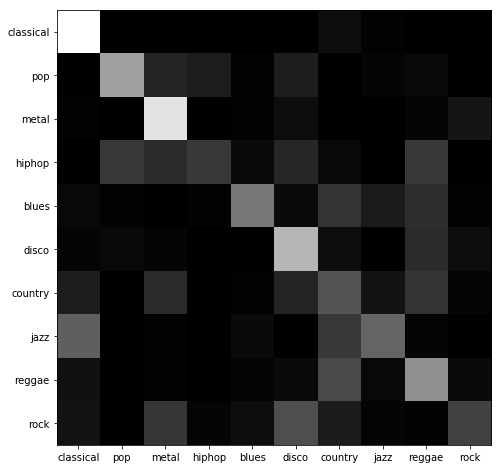

In [0]:
plt.imshow(cm.T, interpolation='nearest', cmap='gray')
plt.xticks(np.arange(0, len(idx_to_genre)), idx_to_genre)
plt.yticks(np.arange(0, len(idx_to_genre)), idx_to_genre)

plt.show()

**Index Local MP3s**

In [0]:
!pip install tinytag

  Stored in directory: /root/.cache/pip/wheels/5c/9d/0e/dfeacf697db577fec40364ccd87a53b6e54bf0fc59f97702f5
Successfully built tinytag


In [0]:
!pip install sounddevice

In [0]:
import os
from tinytag import TinyTag, TinyTagException
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
from keras.models import load_model
import librosa
from collections import Counter
import multiprocessing
from tqdm import tqdm
from keras.models import Model
import numpy as np
import sounddevice as sd

In [0]:
MUSIC_ROOT = '/Users/douwe/Songs/'
mp3s = []
for root, subdirs, files in os.walk(MUSIC_ROOT):
    for fn in files:
        if fn.endswith('.mp3'):
            mp3s.append(os.path.join(root, fn))
len(mp3s)

In [0]:
TO_SKIP = {'Podcast', 'Books & Spoken'}

def process_mp3(path):
    try:
        tag = TinyTag.get(path)
        if tag.genre in TO_SKIP:
            return None
    except TinyTagException:
        print('error')
        return None
    signal, sr = librosa.load(path, res_type='kaiser_fast', offset=30, duration=30)
    try:
        melspec = librosa.feature.melspectrogram(signal, sr=sr).T[:1280,]
        if len(melspec) != 1280:
            return None
    except ValueError:
        return None
    return {'path': path,
            'melspecs': np.asarray(np.split(melspec, 10)),
            'tag': tag}

songs = [process_mp3(path) for path in tqdm(mp3s[:1000])]
songs = [song for song in songs if song]

In [0]:
inputs = []
for song in songs:
    inputs.extend(song['melspecs'])
inputs = np.array(inputs)
inputs.shape

In [0]:
cnn_model = load_model('zoo/15/song_classify.h5')
vectorize_model = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-4].output)
vectors = vectorize_model.predict(inputs)
vectors.shape

In [0]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(vectors)

def most_similar_songs(song_idx):
    distances, indices = nbrs.kneighbors(vectors[song_idx * 10: song_idx * 10 + 10])
    c = Counter()
    for row in indices:
        for idx in row[1:]:
            c[idx // 10] += 1
    return c.most_common()

In [0]:
song_idx = 7
print(songs[song_idx]['path'])

print('---')
for idx, score in most_similar_songs(song_idx)[:5]:
    print(songs[idx]['path'], score)
print('')

**Spotify Playlists**

In [5]:
!python3 -m pip install spotipy

  Stored in directory: /root/.cache/pip/wheels/76/28/19/a86ca9bb0e32dbd4a4f580870250f5aeef852870578e0427e6
Successfully built spotipy


In [0]:
import spotipy
from spotipy import util
from spotipy.client import SpotifyException
from collections import Counter
from gensim.utils import tokenize
import time
import tqdm
import json

In [0]:
CLIENT_ID = '9d4442847caf4c278a9625e51438e8aa'
CLIENT_SECRET = '13b8ef1376cf4b7e98e356f43c1ad9cc'
USER_ID = 'DOsinga'

In [8]:
token = util.prompt_for_user_token(USER_ID, '',
                                   client_id=CLIENT_ID, client_secret=CLIENT_SECRET,
                                   redirect_uri='http://127.0.0.1:8000/callback')
session = spotipy.Spotify(auth=token)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=9d4442847caf4c278a9625e51438e8aa&response_type=code&redirect_uri=http%3A%2F%2F127.0.0.1%3A8000%2Fcallback in your browser


Enter the URL you were redirected to: http://127.0.0.1:8000/callback?code=AQAlzmWlglvRzGOl2khdQAzEWQmuCizwKOiEPOu5nqv3aDpRq67t4y3Kjz7VXY3vJeci6SvDEgs7MuVHbGvBKYcXzp3dy62W2fe0KHP2B1P8icZT5ZERtSLlbSt9LwBlQZP9BcfJHOSn0-2OEvZkmsUyT6mU8l72KFF7QkHMiccPSFt2a8XUJTmK6hED1a52SFW0RQ




SpotifyOauthError: ignored

In [9]:
def find_playlists(session, w, max_count=5000):
    try:
        res = session.search(w, limit=50, type='playlist')
        while res:
            for playlist in res['playlists']['items']:
                yield playlist
                max_count -= 1
                if max_count == 0:
                    raise StopIteration
            tries = 3
            while tries > 0:
                try:
                    res = session.next(res['playlists'])
                    tries = 0
                except SpotifyException as e:
                    tries -= 1
                    time.sleep(0.2)
                    if tries == 0:
                        raise
    except SpotifyException as e:
        status = e.http_status
        if status == 404:
            raise StopIteration
        raise

for pl in find_playlists(session, 'summer'):
    break

pl

NameError: ignored

In [0]:
word_counts = Counter({'a': 1})
playlists = {}
words_seen = set()
playlists = {}
count = 0
dupes = 0

In [0]:
while len(playlists) < 100000:
    for word, _ in word_counts.most_common():
        if not word in words_seen:
            words_seen.add(word)
            print('word>', word)
            for playlist in find_playlists(session, word):
                if playlist['id'] in playlists:
                    dupes += 1
                elif playlist['name'] and playlist['owner']:
                    playlists[playlist['id']] = {
                      'owner': playlist['owner']['id'],
                      'name': playlist['name'],
                      'id': playlist['id'],
                    }
                    count += 1
                    for token in tokenize(playlist['name'], lowercase=True):
                        word_counts[token] += 1
            break

In [0]:
def track_yielder(session, playlist):
    res = session.user_playlist_tracks(playlist['owner'], playlist['id'],
              fields='items(track(id, name, artists(name, id), duration_ms)),next')
    while res:
        for track in res['items']:
            if track['track']:
                yield track['track']
        tries = 3
        while tries > 0:
            try:
                res = session.next(res)
                if not res or  not res.get('items'):
                    raise StopIteration
                tries = 0
            except SpotifyException as e:
                if 400 <= e.http_status <= 499:
                    raise StopIteration
                tries -= 1
                time.sleep(1)
                if tries == 0:
                    raise e

In [0]:
if os.path.isfile('data/songs.db'):
    os.remove('data/songs.db')
conn = sqlite3.connect('data/songs.db')
c = conn.cursor()
c.execute('CREATE TABLE songs (id text primary key, name text, artist text)')
c.execute('CREATE INDEX name_idx on songs(name)')

tracks_seen = set()
with open('data/playlists.ndjson', 'w') as fout_playlists:
    with open('data/songs_ids.txt', 'w') as fout_song_ids:
        for playlist in tqdm.tqdm(playlists.values()):
            fout_playlists.write(json.dumps(playlist) + '\n')
            track_ids = []
            for track in track_yielder(session, playlist):
                track_id = track['id']
                if not track_id:
                    continue
                if not track_id in tracks_seen:
                    c.execute("INSERT INTO songs VALUES (?, ?, ?)", 
                              (track['id'], track['name'], track['artists'][0]['name']))
                track_ids.append(track_id)
            fout_song_ids.write(' '.join(track_ids) + '\n')
            conn.commit()
conn.commit()

**Train a music recommender**

In [0]:
import gensim
import sqlite3
from operator import itemgetter

In [11]:
class WordSplitter(object):
    def __init__(self, filename):
        self.filename = filename
 
    def __iter__(self):
        with open(self.filename) as fin:
            for line in fin:
                yield line.split()
sentences = WordSplitter('/some/directory')
model = gensim.models.Word2Vec(model_input, min_count=4)

NameError: ignored

In [0]:
class WordSplitter(object):
    def __init__(self, filename):
        self.filename = filename
 
    def __iter__(self):
        with open(self.filename) as fin:
            for line in fin:
                yield line.split()
sentences = WordSplitter('/some/directory')
model = gensim.models.Word2Vec(sentences, min_count=4)

In [0]:
model.save(open('zoo/15/songs.word2vec', 'wb'))

In [0]:
conn = sqlite3.connect('data/songs.db')
def find_song(song_name, limit=10):
    c = conn.cursor()
    c.execute("SELECT * FROM songs WHERE UPPER(name) LIKE '%" + song_name + "%'")
    res = sorted((x + (model.wv.vocab[x[0]].count,) 
                  for x in c.fetchall() if x[0] in model.wv.vocab),
                 key=itemgetter(-1), reverse=True)
    return [*res][:limit]

for t in find_song('the eye of the tiger'):
    print(*t)

In [0]:
def suggest_songs(song_id):
    c = conn.cursor()
    similar = dict(model.most_similar([song_id]))
    song_ids = ', '.join(("'%s'" % x) for x in similar.keys())
    c.execute("SELECT * FROM songs WHERE id in (%s)" % song_ids)
    res = sorted((rec + (similar[rec[0]],) for rec in c.fetchall()), 
                 key=itemgetter(-1),
                 reverse=True)
    return [*res]


for t in suggest_songs('4rr0ol3zvLiEBmep7HaHtx'):
    print(*t)